# Dependency Handling

In [1]:
# Install pytorch

!pip3 install torch torchvision torchaudio
#!pip3 install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113

In [2]:
# Install Transformers (using for NLP model - allows for easily import model)
# Install Requests (allow requests to webpages for analysis)
# Install BeautifulSoup (extract relevant data from webpage)
# Install Pandas and Numpy (structure data)

!pip3 install requests transformers beautifulsoup4 pandas numpy

In [3]:
# Tokenizer - Parse through string to get numbers.
# AutoModelForSequenceClassification - Give us architecture from transformers to load in NLP model
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
import torch
import requests
from bs4 import BeautifulSoup
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('max_colwidth', 400)

C:\Users\dawoo\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Setup Model (Initialization)

In [4]:
# Multilingual dataset -- based on latin scripts
tokenizer = AutoTokenizer.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')
model = AutoModelForSequenceClassification.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')

# Arabic dataset -- based on abjad scripts
DA = pipeline('text-classification', model='CAMeL-Lab/bert-base-arabic-camelbert-da-sentiment')
MSA = pipeline('sentiment-analysis', model='CAMeL-Lab/bert-base-arabic-camelbert-msa-sentiment')
CA = pipeline('sentiment-analysis', model='CAMeL-Lab/bert-base-arabic-camelbert-ca-sentiment')
MIX = pipeline('sentiment-analysis', model='CAMeL-Lab/bert-base-arabic-camelbert-mix-sentiment')
sentences = ['أنا بخير']
tmp = DA(sentences)

In [5]:

len(tmp)
tmp
tmp[0]['label']

'positive'

# Encoding and Sentiment Calculation

In [6]:
tokens0 = tokenizer.encode('I am having a horrible day', return_tensors='pt') 
tokens1 = tokenizer.encode('Yay!!', return_tensors='pt') # Means "happy" 
tokens2 = tokenizer.encode('اِک شخص بددُعا سی کر گیا مُجھ پر, وُہ عہدِ ترقِ وفَاسِی کرگیا مُجھ پر', return_tensors='pt') # Negative sentence
tokens0

tensor([[  101,   151, 10345, 13594,   143, 36129, 45795, 10301, 11111,   102]])

In [7]:
# Debug

# tokens
# tokens[0]
# tokenizer.decode(tokens[0])

In [8]:
result0 = model(tokens0)
result1 = model(tokens1)
result2 = model(tokens2)

In [9]:
print(result0)
print(result1)
print(result2)

SequenceClassifierOutput(loss=None, logits=tensor([[ 3.3005,  1.4749, -0.0459, -2.0774, -2.0999]],
       grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)
SequenceClassifierOutput(loss=None, logits=tensor([[-0.3081, -0.2168,  0.1382, -0.0173,  0.3923]],
       grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)
SequenceClassifierOutput(loss=None, logits=tensor([[-0.0923, -0.5614, -0.0990, -0.1329,  0.6934]],
       grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)


In [10]:
star_rating0 = int(torch.argmax(result0.logits)) + 1
star_rating1 = int(torch.argmax(result1.logits)) + 1
star_rating2 = int(torch.argmax(result2.logits)) + 1

print('Star Rating (result0): ', star_rating0)
print('Star Rating (result1): ', star_rating1)
print('Star Rating (result2): ', star_rating2)


Star Rating (result0):  1
Star Rating (result1):  5
Star Rating (result2):  5


#  Parse Website

In [11]:
headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/96.0.4664.93 Safari/537.36'}
req_sad = requests.get('https://hamariweb.com/poetries/sad_poetries2.aspx', headers=headers)
req_funny = requests.get('https://hamariweb.com/poetries/funny_poetries4.aspx', headers=headers)

soup_sad = BeautifulSoup(req_sad.text, 'html.parser')
soup_funny = BeautifulSoup(req_funny.text, 'html.parser')

regex_sad = re.compile('UrduText')
regex_funny = re.compile('UrduText')

result_website_sad = soup_sad.find_all('a', {'class':regex_sad})
result_website_funny = soup_funny.find_all('a', {'class':regex_funny})

reviews_sad = [i.text for i in result_website_sad]
reviews_funny = [i.text for i in result_website_funny]

# Debug
#reviews_sad
#reviews_funny


# Load Website Data into Dataframe and Get Star Rating

In [12]:
df_sad = pd.DataFrame(np.array(reviews_sad), columns=['string'])
df_funny = pd.DataFrame(np.array(reviews_funny), columns=['string'])

# Debug
#soup
#result_website
#reviews
#df['string'].iloc[1]

In [13]:
def StringToScore(string):
    tokens = tokenizer.encode(string, return_tensors='pt')
    output = model(tokens)
    return int(torch.argmax(output.logits)) + 1

def StringToScore_Ar(string):
    output = MSA(string)
    return output
    

In [14]:
# Debug
#StringToScore(df_sad['string'].iloc[0])

In [15]:
df_sad['sentiment'] = df_sad['string'].apply(lambda x: StringToScore(x[:512]))
#df_sad['string'] = df_sad['string'].replace('\n','')
df_funny['sentiment'] = df_funny['string'].apply(lambda x: StringToScore(x[:512]))

In [16]:
df_sad

,string,sentiment
0,\nتمہاری منتظر یوں تو ہزاروں گھر بناتی ہوںوہ رستہ بنتے جاتے ہیں کچھ اتنے در بناتی ہوں...,1
1,\nہم انہیں وہ ہمیں بھلا بیٹھےدو گنہ گار زہر کھا بیٹھے...,1
2,\nخنجر سے کرو بات نہ تلوار سے پوچھومیں قتل ہوا کیسے مرے یار سے پوچھو...,1
3,\nوہ شخص حسن اپنا دکھا کر چلا گیادیوانہ مجھ کو اپنا بنا کر چلا گیا...,5
4,اے نگاہ دوست یہ کیا ہو گیا کیا کر دیاپہلے پہلے روشنی دی پھر اندھیرا کر دیا...,1
5,رواں دواں ہے زندگی چراغ کے بغیر بھیہے میرے گھر میں روشنی چراغ کے بغیر بھی...,3
6,وہ ہنس ہنس کے وعدے کیے جا رہے ہیںفریب تمنا دیے جا رہے ہیں...,5
7,چشم نم پر مسکرا کر چل دیئےآگ پانی میں لگا کر چل دیئے...,1
8,چاہت کی اذیت رہائی نہ دے گیکہ بچنےکی راہ بھی دکھائی نہ دےگی...,1
9,کون جیتا کون ہارا یہ کہانی پھر سہیہوگا کیسے اب گزارہ یہ کہانی پھر سہی...,3


In [17]:
df_funny

,string,sentiment
0,دھوبی کا کتا ہوں گھر کا نہ گھاٹ کابیگم بارہا کہہ چکیں دشمن ہوں اناج کا...,1
1,کبھی دادی لگتی ھے کبھی نانی لگتی ھے ماڈل ھے پرانہ مگر گڑیا جاپانی لگتی ھے...,2
2,ابتدا عشق میں یوں ہوا دل خراب آدھاکے جیسے سیکھ پر چڑھتے ہی جل جائے کباب آدھا...,2
3,"وہ جب ناراض ہوتے ہیں تو ""کانپیں ٹانگ"" جاتی ہیں کسی سے کچھ نہ کہتے ہیں تو ""کانپیں ٹانگ"" جاتی ہیں ...",1
4,اتنا دبلا ہو گیا ہوں صنم تیری جدائی سےکھٹمل بھی کھینچ لیتے ہیں مجھے چارپائی سے...,1
5,ہم نے مانا کہ رپلائی نہ کرو گے تم لیکنٹرائی کرتے رہیں گے ہم بھی بلاک ہونے تک...,1
6,جس بھی شادی میں جاتا ہوںکسی نہ کسی لڑکی سے پیار ہوجاتا ہے...,1
7,اگر تمہارے وعدے نہ ہوتے کچےتو اب ہوتے ہمارے دو بچے...,1
8,یہ اتوار نہیں آساں بس اِتنا ہی سمجھ لیجئےاِک کپڑوں کا دریا ہے اور دھوکے سُکھانا ہے...,1
9,گھر میں اگر کوئی عقل کی بات کردوتو سب یہی پوچھتے ہیں...,1


In [18]:
print("Average Sentiment (Sad Poetry): ", df_sad['sentiment'].mean())

Average Sentiment (Sad Poetry):  2.5416666666666665


In [19]:
print("Average Sentiment (Funny Poetry): ", df_funny['sentiment'].mean())

Average Sentiment (Funny Poetry):  2.05


In [20]:
#np.savetxt(r'text_sad.txt', df_sad['string'].values, fmt='%s', encoding='utf-8')
#np.savetxt(r'text_funny.txt', df_funny['string'].values, fmt='%s', encoding='utf-8')

# Create non-diacritized and diacritized dataframe

In [21]:
df_funny_final = pd.read_csv("text_funny.txt", sep="\\n", names=['ND String'], encoding='utf8')
df_funny_final['ND Sentiment Label'] = df_funny_final['ND String'].apply(lambda x: StringToScore_Ar(x[:1024])[0]['label'])
df_funny_final['ND Sentiment Score'] = df_funny_final['ND String'].apply(lambda x: StringToScore_Ar(x[:1024])[0]['score'])
temp = pd.read_csv("predictions_d3_funny.txt", sep="\\n", names=['D String'], encoding='utf8')
df_funny_final['D String'] = temp['D String']
df_funny_final['D Sentiment Label'] = df_funny_final['D String'].apply(lambda x: StringToScore_Ar(x[:1024])[0]['label'])
df_funny_final['D Sentiment Score'] = df_funny_final['D String'].apply(lambda x: StringToScore_Ar(x[:1024])[0]['score'])

C:\Users\dawoo\AppData\Local\Temp\ipykernel_37380\3361357922.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df_funny_final = pd.read_csv("text_funny.txt", sep="\\n", names=['ND String'], encoding='utf8')
C:\Users\dawoo\AppData\Local\Temp\ipykernel_37380\3361357922.py:4: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  temp = pd.read_csv("predictions_d3_funny.txt", sep="\\n", names=['D String'], encoding='utf8')


In [22]:
df_funny_final

,ND String,ND Sentiment Label,ND Sentiment Score,D String,D Sentiment Label,D Sentiment Score
0,دھوبی کا کتا ہوں گھر کا نہ گھاٹ کابیگم بارہا کہہ چکیں دشمن ہوں اناج کا,neutral,0.792972,دھوَبْیُ ُکا کَتَاْ ہوَّںَ گھَرَ ُکاَ َنٍہ ُگْھَاَٹَ ٍکاَبَیَگمَ َبُاُرہا َکِہَہ ُچُّکیَںَ ِدِشمن َہَوِںَ ُانِاْجُ کِا,neutral,0.827521
1,کبھی دادی لگتی ھے کبھی نانی لگتی ھے ماڈل ھے پرانہ مگر گڑیا جاپانی لگتی ھے,neutral,0.858894,َ ْکُبُھی داَدَیَ َلگتیَّ ھِےِ ُّکبِھَّیَ َنانی َلِگْتیَ َھَے َمْاِڈلَ ھےْ َپْرِاِنہَ ُمَگر ْگُڑْیَاَ ُجاپاَنُیِ َلگِتْی َھْےِ,neutral,0.837183
2,"وہ جب ناراض ہوتے ہیں تو ""کانپیں ٹانگ"" جاتی ہیں کسی سے کچھ نہ کہتے ہیں تو ""کانپیں ٹانگ"" جاتی ہیں",neutral,0.943657,"وَہَ ِجُب َنَاْرِاضَ َّہوَتےِ َہیں َّتُو َ""ْ ِکاَنَپْیِںِ ٹَاْنَگ َ""ُ جَاَتیٌ ہیَّں کسَی سَے َکچھْ َنْہُ کَہْتے ہَّیَں ِتوَ َ""ِ َکاَنَّپُیںَ ٹاَنِگُ ""َ جًاتِی ہیْں",neutral,0.928927
3,اتنا دبلا ہو گیا ہوں صنم تیری جدائی سےکھٹمل بھی کھینچ لیتے ہیں مجھے چارپائی سے,neutral,0.937072,اُتَنْاٍ دَبلَا َہِوْ ُگیَاِ ہوُںَ ِّصُنمَ ْتیَرَّیَ جدْاُئَیِ ِّسےَکھَٹمَلَ ْبُھیَ ِکًّھینَچِ َلیتےَّ ُہیَںْ ُمجَھِےَ چَاَرپائْیِ ْسَےِ,neutral,0.827521
4,ہم نے مانا کہ رپلائی نہ کرو گے تم لیکنٹرائی کرتے رہیں گے ہم بھی بلاک ہونے تک,neutral,0.915068,ہَمَ َنے َمْاٌناَ ْکُہ ٌرپَلْاُئی نہ کرو گے تم لیکنٹرائی کرتے رہیں گے ہم بھی بلاک ہونے تک,neutral,0.938796
5,جس بھی شادی میں جاتا ہوںکسی نہ کسی لڑکی سے پیار ہوجاتا ہے,neutral,0.873238,جَسْ بھیَ ِشاِدی مَیُںَ َجاتاَ َہْوِںکسْیِ نہْ َکسِی لڑکی سے پیار ہوجاتا ہے,neutral,0.855343
6,اگر تمہارے وعدے نہ ہوتے کچےتو اب ہوتے ہمارے دو بچے,neutral,0.838007,اِگَرَّ ُتْمہَاْرَےُ َوعدْےُ ْنہَ ہَوتےُ َکچِےُتوَ َابِ َہُوْتے ہَمْاِرے َدو َّبُچےَ,neutral,0.777999
7,یہ اتوار نہیں آساں بس اِتنا ہی سمجھ لیجئےاِک کپڑوں کا دریا ہے اور دھوکے سُکھانا ہے,neutral,0.858633,یَہْ ُاُتوار َنُہَیں آَسْاں بَّس ِاَتُناَ ِہْیُ ُسمُجَھ َلیًجئِےْاَکَ ِکپَڑُوَں َکْاُ ُدرُیَاَّ ٌہے اَوَرُ دُھوَکْےِ سُکُھاَنْاً ہے,neutral,0.860124
8,گھر میں اگر کوئی عقل کی بات کردوتو سب یہی پوچھتے ہیں,neutral,0.865924,گھرَّ َمِیں اگَرْ کَوِئَی عقَّلَ کیُ ٌّباِتْ ُکَردوَتَّوُ سَب یَہْیَ ُپوَچْھَتےَ ہیَںَ,neutral,0.793181
9,افریقہ میں ایک کالے شوہر نےاپنی کالی بیوی کو کالی رات میں,neutral,0.863611,افرَیْقُہُ میںَ ُاْیَکَ ُکاِلے َشَوہر ْنُےْاِپنَیْ کَاُلیَ بُیَّوِیً کوِ کْاِلْیَ رِات مَیَںْ,neutral,0.793181


In [23]:
df_sad_final = pd.read_csv("text_sad.txt", sep="\\n", names=['ND String'], encoding='utf8')
df_sad_final['ND Sentiment Label'] = df_sad_final['ND String'].apply(lambda x: StringToScore_Ar(x[:1024])[0]['label'])
df_sad_final['ND Sentiment Score'] = df_sad_final['ND String'].apply(lambda x: StringToScore_Ar(x[:1024])[0]['score'])
#df_sad_final['ND Sentiment Score'] = df_sad_final['ND String'].apply(lambda x: StringToScore_Ar(x[:1024]))
temp = pd.read_csv("predictions_d3_sad.txt", sep="\\n", names=['D String'], encoding='utf8')
df_sad_final['D String'] = temp['D String']
df_sad_final['D Sentiment Label'] = df_sad_final['D String'].apply(lambda x: StringToScore_Ar(x[:1024])[0]['label'])
df_sad_final['D Sentiment Score'] = df_sad_final['D String'].apply(lambda x: StringToScore_Ar(x[:1024])[0]['score'])

C:\Users\dawoo\AppData\Local\Temp\ipykernel_37380\999515393.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df_sad_final = pd.read_csv("text_sad.txt", sep="\\n", names=['ND String'], encoding='utf8')
C:\Users\dawoo\AppData\Local\Temp\ipykernel_37380\999515393.py:5: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  temp = pd.read_csv("predictions_d3_sad.txt", sep="\\n", names=['D String'], encoding='utf8')


In [24]:
df_sad_final

,ND String,ND Sentiment Label,ND Sentiment Score,D String,D Sentiment Label,D Sentiment Score
0,تمہاری منتظر یوں تو ہزاروں گھر بناتی ہوںوہ رستہ بنتے جاتے ہیں کچھ اتنے در بناتی ہوں,neutral,0.867050,تمہَاْرُیُ منتَظَرْ یوَّںَ توَ َہُزاَرَوٍں ُگْھَرَ َبٍناَتَیَ ہَوَںُوُہ رسَتِہَ بُنُّتےَ َجِاِتے ہَیَںِ َکُچھِ ْاُتنِے َدِرَ بنَاِتْیُ ہُوْںِ,neutral,0.837183
1,ہم انہیں وہ ہمیں بھلا بیٹھےدو گنہ گار زہر کھا بیٹھے,neutral,0.897718,ہَمْ ُاُنہیں َوَہَ َہمیںَّ بِھِلُّا ِبَّیَٹَھےدو َگِنْہ َگَاَر َزْہِر َکھاْ َبْیِٹِھےَ,neutral,0.777999
2,وہ شخص حسن اپنا دکھا کر چلا گیادیوانہ مجھ کو اپنا بنا کر چلا گیا,positive,0.901860,وَہَ ِشُخصَ َحْسِن َاَّپنَا ِدَکھا َّکُر َچْلِا َگَیْاِدِیوَاْنَہ َمُجھَ َکوٌ اپَّنا بَنا َکرَ چلْاَ ْگُیاَ,neutral,0.826177
3,اے نگاہ دوست یہ کیا ہو گیا کیا کر دیاپہلے پہلے روشنی دی پھر اندھیرا کر دیا,neutral,0.752248,اُےَ ْنٍگاَہ َدوَسِتْ ُیہَ ِکیاُ َہِّوُ گَیْا َکَّیَا کْرُ َدِیِّاپَہلَے َپَہْلُے َرِوًّشنیَ ِدَی پھَّرُ اَنْدُھیَرِاَ کَرَ دیاْ,neutral,0.837183
4,رواں دواں ہے زندگی چراغ کے بغیر بھیہے میرے گھر میں روشنی چراغ کے بغیر بھی,neutral,0.857459,رَوَاَں دَوْاٌں َہْےُ زٌندَگْیُ چراغ کے بغیر بھیہے میرے گھر میں روشنی چراغ کے بغیر بھی,neutral,0.871695
5,وہ ہنس ہنس کے وعدے کیے جا رہے ہیںفریب تمنا دیے جا رہے ہیں,neutral,0.912865,وَہْ ہنسَ ِہنِس کےَ ُوَعَدے کَیَےْ ِجا ْرِہے ْہَیںِفریب تمنا دیے جا رہے ہیں,neutral,0.882258
6,چشم نم پر مسکرا کر چل دیئےآگ پانی میں لگا کر چل دیئے,neutral,0.875380,چِشَمَّ ُنْم َپْرَ ُمَسکرْاُ ْکرَ چَل دُیَئےِآُگ َپَانِیَ ُمْیں لَگْاِ کرَ چلَّ ُدیَئْےَ,neutral,0.810383
7,چاہت کی اذیت رہائی نہ دے گیکہ بچنےکی راہ بھی دکھائی نہ دےگی,neutral,0.867566,چَاْہُتُ کی اَذُیَت رہَاْئی نَّہ ِدَےُ گَیِکْہُ ُبچُنَےکَی ًراِہْ َبَھِی َدُکَھاَئْیُ ُنہُ َدَّےٌگی,neutral,0.726826
8,کون جیتا کون ہارا یہ کہانی پھر سہیہوگا کیسے اب گزارہ یہ کہانی پھر سہی,neutral,0.846052,کونَّ َجِیتا کَوْن َہِاَرا یَّہَ کہُاٌّنیِ ْپُھَر سَہَّیُہوَگا َکْیَسُے َاْبَ گَزارَہَ َیہِ ِکہاْنَیْ ُپھر َسِہَّیُ,neutral,0.826177
9,ہر آئنے میں ترے خد و خال آتے ہیںعجیب رنج ترے آشنا اٹھاتے ہیں,neutral,0.895861,ہر َآْئُنُے میَںُ ْتَرَےُ خِد وَ َخال ْآُتْےِ ہَیْںعَجُیبَ رُنَّجِ ًترےِ اْ ِْٓ َشنِا اٹَھَاْتے ْہَیَںَ,neutral,0.718979


# Generate plots

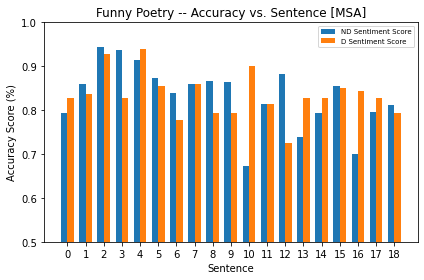

In [25]:
fig, ax = plt.subplots()
width = 0.35
x = np.arange(19)
rects1 = ax.bar(x - width/2, df_funny_final['ND Sentiment Score'], width, label='ND Sentiment Score')
rects2 = ax.bar(x + width/2, df_funny_final['D Sentiment Score'], width, label='D Sentiment Score')
#df_funny_final['ND Sentiment Score'].plot(subplots=True, figsize=(7, 7), kind='bar'); 
#df_funny_final['D Sentiment Score'].plot(subplots=True, figsize=(7, 7), kind='bar', color='red'); 
plt.legend(loc=0,  prop={'size': 7})
plt.title('Funny Poetry -- Accuracy vs. Sentence [MSA]')
ax.set_xticks(x, x)
plt.xlabel('Sentence')
plt.ylabel('Accuracy Score (%)')
plt.ylim(0.5, 1.0)
#plt.figure()
fig.tight_layout()
plt.savefig('MSA/neutral_funny.png')
plt.show()
#sns.catplot(x="String Number", y="Accuracy Score (%)", data=df_funny_final, kind="bar")

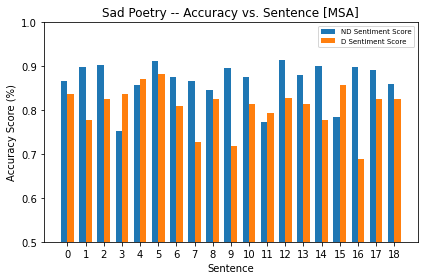

In [26]:
fig, ax = plt.subplots()
width = 0.35
x = np.arange(19)
rects1 = ax.bar(x - width/2, df_sad_final['ND Sentiment Score'], width, label='ND Sentiment Score')
rects2 = ax.bar(x + width/2, df_sad_final['D Sentiment Score'], width, label='D Sentiment Score')
plt.legend(loc=0,  prop={'size': 7})
plt.title('Sad Poetry -- Accuracy vs. Sentence [MSA]')
ax.set_xticks(x, x)
plt.xlabel('Sentence')
plt.ylabel('Accuracy Score (%)')
plt.ylim(0.5, 1.0)
fig.tight_layout()
plt.savefig('MSA/neutral_sad.png')
plt.show()